In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from scipy import spatial
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
import timm
from timm.utils import AverageMeter
import sys
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer

In [ ]:
class CFG:
    model_name = 'vit_base_patch16_224'
    input_size = 224
    batch_size = 64
    num_epochs = 5
    lr = 1e-4
    seed = 42

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True


seed_everything(CFG.seed)

In [ ]:
class DiffusionDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath'])
        image = self.transform(image)
        prompt = row['prompt']
        return image, prompt


class DiffusionCollator:
    def __init__(self):
        self.st_model = SentenceTransformer(
            '/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2',
            device='cpu'
        )
    
    def __call__(self, batch):
        images, prompts = zip(*batch)
        images = torch.stack(images)
        prompt_embeddings = self.st_model.encode(
            prompts, 
            show_progress_bar=False, 
            convert_to_tensor=True
        )
        return images, prompt_embeddings
    
    
def get_dataloaders(
    trn_df,
    val_df,
    input_size,
    batch_size
):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    trn_dataset = DiffusionDataset(trn_df, transform)
    val_dataset = DiffusionDataset(val_df, transform)
    collator = DiffusionCollator()
    
    dataloaders = {}
    dataloaders['train'] = DataLoader(
        dataset=trn_dataset,
        shuffle=True,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        collate_fn=collator
    )
    dataloaders['val'] = DataLoader(
        dataset=val_dataset,
        shuffle=False,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=False,
        collate_fn=collator
    )
    return dataloaders

In [ ]:
val_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }
train_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }

In [ ]:
def cosine_similarity(y_trues, y_preds):
    return np.mean([
        1 - spatial.distance.cosine(y_true, y_pred) 
        for y_true, y_pred in zip(y_trues, y_preds)
    ])

In [ ]:
def train(
    trn_df,
    val_df,
    model_name,
    input_size,
    batch_size,
    num_epochs,
    lr
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataloaders = get_dataloaders(
        trn_df,
        val_df,
        input_size,
        batch_size
    )

    model = timm.create_model(
        model_name,
        pretrained=False,
        num_classes=384
    )
    model.load_state_dict(torch.load('/kaggle/input/trained-vit-stablediffusion/vit_base_patch16_224.pth'))
    model.set_grad_checkpointing()
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    ttl_iters = num_epochs * len(dataloaders['train'])
    scheduler = CosineAnnealingLR(optimizer, T_max=ttl_iters, eta_min=1e-6)
    criterion = nn.CosineEmbeddingLoss()
    
    best_score = -1.0

    for epoch in range(num_epochs):
        train_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }
        model.train()
        for X, y in tqdm(dataloaders['train'], leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            X_out = model(X)
            target = torch.ones(X.size(0)).to(device)
            loss = criterion(X_out, y, target)
            loss.backward()

            optimizer.step()
            scheduler.step()

            trn_loss = loss.item()
            trn_cos = cosine_similarity(
                X_out.detach().cpu().numpy(), 
                y.detach().cpu().numpy()
            )

            train_meters['loss'].update(trn_loss, n=X.size(0))
            train_meters['cos'].update(trn_cos, n=X.size(0))

        print('Epoch {:d} / trn/loss={:.4f}, trn/cos={:.4f}'.format(
            epoch + 1,
            train_meters['loss'].avg,
            train_meters['cos'].avg))

        val_meters = {
            'loss': AverageMeter(),
            'cos': AverageMeter(),
        }
        model.eval()
        for X, y in tqdm(dataloaders['val'], leave=False):
            X, y = X.to(device), y.to(device)

            with torch.no_grad():
                X_out = model(X)
                target = torch.ones(X.size(0)).to(device)
                loss = criterion(X_out, y, target)

                val_loss = loss.item()
                val_cos = cosine_similarity(
                    X_out.detach().cpu().numpy(), 
                    y.detach().cpu().numpy()
                )

            val_meters['loss'].update(val_loss, n=X.size(0))
            val_meters['cos'].update(val_cos, n=X.size(0))

        print('Epoch {:d} / val/loss={:.4f}, val/cos={:.4f}'.format(
            epoch + 1,
            val_meters['loss'].avg,
            val_meters['cos'].avg))
        
        if val_meters['cos'].avg > best_score:
            best_score = val_meters['cos'].avg
            torch.save(model.state_dict(), f'{model_name}.pth')

df = pd.read_csv('/kaggle/working/update_diffusiondb.csv')
trn_df, val_df = train_test_split(df, test_size=0.1, random_state=CFG.seed)

In [ ]:
print(df.head)

In [ ]:
train(trn_df, val_df, CFG.model_name, CFG.input_size, CFG.batch_size, CFG.num_epochs, CFG.lr)

  0%|          | 0/1467 [00:00<?, ?it/s]

Epoch 1 / trn/loss=0.4033, trn/cos=0.5967


  0%|          | 0/163 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1 / val/loss=0.4511, val/cos=0.5489


  0%|          | 0/1467 [00:00<?, ?it/s]

Epoch 2 / trn/loss=0.3669, trn/cos=0.6331


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2 / val/loss=0.4461, val/cos=0.5539


  0%|          | 0/1467 [00:00<?, ?it/s]

Epoch 3 / trn/loss=0.3226, trn/cos=0.6774


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3 / val/loss=0.4474, val/cos=0.5526


  0%|          | 0/1467 [00:00<?, ?it/s]

Epoch 4 / trn/loss=0.2775, trn/cos=0.7225


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4 / val/loss=0.4536, val/cos=0.5464


  0%|          | 0/1467 [00:00<?, ?it/s]

Epoch 5 / trn/loss=0.2468, trn/cos=0.7532


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5 / val/loss=0.4625, val/cos=0.5375


In [ ]:
import csv

# Open CSV file
with open('/kaggle/input/diffusiondb-data-cleansing/diffusiondb.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Find length of CSV file
    length = len(list(reader))
    print(f"CSV file length: {length}")
    
    

CSV file length: 154321


In [ ]:
import pandas as pd

# Specify the path to your input CSV file
input_csv_path = '/kaggle/input/diffusiondb-data-cleansing/diffusiondb.csv'

# Specify the path for the output CSV file
output_csv_path = 'test.csv'

# Read the input CSV file using pandas
data_frame = pd.read_csv(input_csv_path)

# Get the last 15,000 rows
last_15000_rows = data_frame.tail(15000)

# Save the last 15,000 rows to the output CSV file
last_15000_rows.to_csv(output_csv_path, index=False)

In [ ]:
import csv

# Open original CSV file and new CSV file
with open('/kaggle/input/diffusiondb-data-cleansing/diffusiondb.csv', newline='') as csvfile, open('update_diffusiondb.csv', 'w', newline='') as newfile:
    reader = csv.reader(csvfile)
    writer = csv.writer(newfile)
    # Slice to remove the last 50k rows
    rows_to_keep = list(reader)[:-50000]
    # Write remaining rows to new file
    writer.writerows(rows_to_keep)

In [ ]:
test_df = pd.read_csv('/kaggle/working/test.csv')
#trn_df, val_df = train_test_split(df, test_size=0.1, random_state=CFG.seed)


In [ ]:
transform = transforms.Compose([
        transforms.Resize(CFG.input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
collator = DiffusionCollator()
test_dataset = DiffusionDataset(test_df, transform)
dataloader = DataLoader(
        dataset=test_dataset,
        shuffle=True,
        batch_size=CFG.batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        collate_fn=collator
    )

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model(
    CFG.model_name,
    pretrained=False,   # Make sure to set this to False since we are loading custom weights
    num_classes=384
).to(device)
model.load_state_dict(torch.load('/kaggle/input/vit-8epochs/vit_base_patch16_224.pth'))


<All keys matched successfully>

In [ ]:
predictions = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for X, y in tqdm(dataloader, leave=False):
    X, y = X.to(device), y.to(device)
    with torch.no_grad():
        for batch in dataloader:
            X_out = model(X)
            val_cos = cosine_similarity(
                X_out.detach().cpu().numpy(), 
                y.detach().cpu().numpy()
            )
            predictions.append(val_cos)
print("Cosine Similarity: "+sum(predictions)/len(predictions))


Cosine Similarity: 0.337825


In [16]:
import plotly.graph_objects as go
import plotly.io as pio
x = [i for i in range(1,8)]
y1 = train_meters['loss']
y2 = train_meters['cos']
z1 = val_meters['loss']
z2 = val_meters['cos']
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Train Loss', line=dict(color="red"))
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Train Cosine Similarity', line=dict(color="blue"))
trace3 = go.Scatter(x=x, y=z1, mode='lines', name='Validation Loss', line=dict(color="green"))
trace4 = go.Scatter(x=x, y=z2, mode='lines', name='Validation Cosine Similarity', line=dict(color="black"))
layout = go.Layout(title='ViT Model for Image Prompt Generation', xaxis=dict(title='Number of epochs'), yaxis=dict(title='Value'))
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()
pio.write_image(fig,"vit_plot.png")

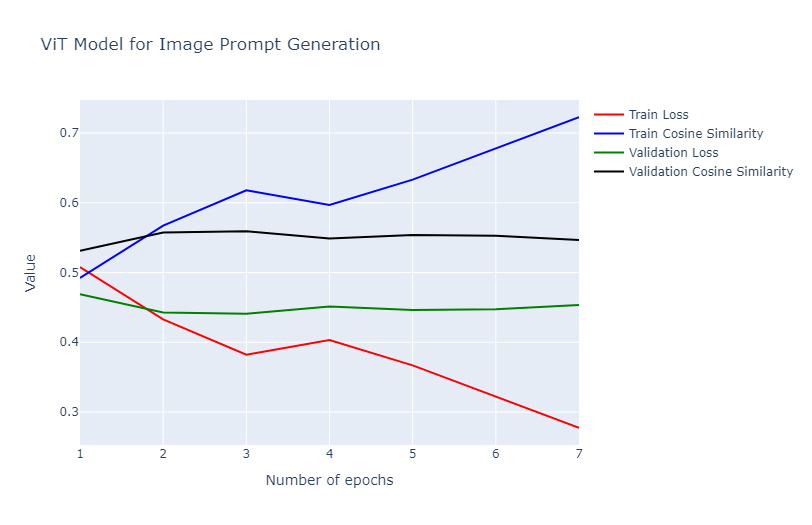

In [17]:
from PIL import Image
image_path = 'vit_plot.png'
image = Image.open(image_path)
image.show()